In [1]:
from chase.base import *
from chase.utils import *
from chase.fit import *
import pickle
from mypy.explib.frey2014 import frey2014
pd.set_option('display.max_colwidth', 100)
sns.set_style("whitegrid")

FIGDEST = '/Users/markant/Dropbox/Apps/ShareLaTeX/ssDFE/ssDFE_v3/figures/'

def lookup_bic(fitdf, switching, stoprule, weighting):
    return fitdf[(fitdf.switching==switching) & 
                 (fitdf.stoprule==stoprule) &
                 (fitdf.weighting==weighting)].bic.values[0]

COMPARISON_RESULTS = {}

def model_table(sid, force=False):
    if sid not in COMPARISON_RESULTS or force:
        COMPARISON_RESULTS[sid] = pd.read_csv(OUTDIR+'/modelcomparison_subj=%s.csv' % sid, index_col=0)
    return COMPARISON_RESULTS[sid]

In [4]:
data = pd.read_csv('data/frey_data.csv', index_col=0)
problems = {gid: frey2014.get_options(gid) for gid in data.problem.unique()}

with open('data/frey_switchrates.pkl', 'r') as f:
    emp_p_switch = pickle.load(f)

In [5]:
# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 50],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'mu': [0., np.inf, 10.],
        'sc': [0., np.inf, 1.],
        'p_stop': [0, 1, .5]}

# parameters that are set to fixed values 
FIXED = {'c': 0.5,
         'theta': 30}
FIXED_OPT = {'c': 0.5}

OUTDIR = 'chase_fitresults_frey_individual'

PARSETS_GEOM = [['p_stop', 'p_stay', 'tau'],
                ['p_stop', 'p_stay', 'tau', 'prelec_gamma'],
                ['p_stop', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                ['p_stop', 'p_stay', 'tau', 'pow_gain'],
               ]

PARSETS_NORMAL = [['mu', 'sc', 'p_stay', 'tau'],
                  ['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma'],
                  ['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                  ['mu', 'sc', 'p_stay', 'tau', 'pow_gain'],
                  ]

PARSETS_OPT = [['theta', 'p_stay', 'tau'],
               ['theta', 'p_stay', 'tau', 'prelec_gamma'],
               ['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
               ['theta', 'p_stay', 'tau', 'pow_gain'],
              ]

In [6]:
data.subject.unique()[:45]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  15,  16,
        17,  18,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39, 100, 101, 102, 103,
       104, 106, 109, 110, 111, 112])

In [7]:
for sid in data.subject.unique():

    #print sid
    
    results = pd.DataFrame([], columns=['sim_id', 'stoprule', 'weighting', 'switching',
                                        'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                        'theta', 'p_stop', 'mu', 'sc', 
                                        'prelec_gamma', 'prelec_elevation',
                                        'pow_gain', 'w_loss'])
    
    for i, parset in enumerate(PARSETS_OPT):
        model_id = 'frey_individual_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED_OPT, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'optional'
        results.loc[results.shape[0]-1,'switching'] = False
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]

    for i, parset in enumerate(PARSETS_GEOM):
        model_id = 'frey_individual_planned_geom_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'geom'
        results.loc[results.shape[0]-1,'switching'] = False
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]

    for i, parset in enumerate(PARSETS_NORMAL):
        model_id = 'frey_individual_planned_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'normal'
        results.loc[results.shape[0]-1,'switching'] = False
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]

    # switching, optional stopping
    for i, parset in enumerate(PARSETS_OPT):
        model_id = 'frey_individual_switching_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        fixed = deepcopy(FIXED_OPT)
        fixed['p_switch'] = emp_p_switch[sid]
        try:
            b = best_result(model_id, fixed, fitting, outdir=OUTDIR)
            results.loc[results.shape[0]] = b
            results.loc[results.shape[0]-1,'stoprule'] = 'optional'
            results.loc[results.shape[0]-1,'switching'] = True
            results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]
        except:
            print '\nfailed for subj=%s' % sid
            print parset

    # switching, planned stopping
    for i, parset in enumerate(PARSETS_NORMAL):
        model_id = 'frey_individual_switching_planned_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        fixed = deepcopy(FIXED)
        fixed['p_switch'] = emp_p_switch[sid]
        try:
            b = best_result(model_id, fixed, fitting, outdir=OUTDIR)
            results.loc[results.shape[0]] = b
            results.loc[results.shape[0]-1,'stoprule'] = 'normal'
            results.loc[results.shape[0]-1,'switching'] = True
            results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]
        except:
            print '\nfailed for subj=%s' % sid
            print parset

 
    results.loc[results.switching==0,'switching'] = False
    results.sort('bic', inplace=True)
    
    w = np.exp(-.5 * (results.bic - results.iloc[0].bic)).values
    w = w/w.sum()
    results['W_bic'] = w

    results.to_csv(OUTDIR+'/modelcomparison_subj=%s.csv' % sid)

In [9]:
model_table(27)

,sim_id,stoprule,weighting,switching,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss,W_bic
9,"frey_individual_planned_subj=27(mu,p_stay,prelec_gamma,sc,tau|c=0.5,theta=30)",normal,prob1,False,5,84,331.306970,684.768025,6.510758e-08,6.085581e-01,30,NaN,28.928066,6.971717,1.555024,NaN,NaN,NaN,NaN
10,"frey_individual_planned_subj=27(mu,p_stay,prelec_elevation,prelec_gamma,sc,tau|c=0.5,theta=30)",normal,prob2,False,6,84,331.559843,689.704587,2.732787e-10,7.046888e-01,30,NaN,28.928065,6.971718,1.507802,1.091537,NaN,NaN,NaN
8,"frey_individual_planned_subj=27(mu,p_stay,sc,tau|c=0.5,theta=30)",normal,none,False,4,84,336.895625,691.514517,6.796199e-07,5.188821e-07,30,NaN,28.928061,6.971713,NaN,NaN,NaN,NaN,NaN
16,"frey_individual_switching_planned_subj=27(mu,p_stay,sc,tau|c=0.5,p_switch=0.069,theta=30)",normal,none,True,4,84,337.041311,691.805890,8.855308e-01,1.918683e-02,30,NaN,28.940032,6.559492,NaN,NaN,NaN,NaN,NaN
11,"frey_individual_planned_subj=27(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)",normal,value1,False,5,84,335.124773,692.403630,4.366997e-06,9.243655e-02,30,NaN,28.928066,6.971717,NaN,NaN,0.774604,NaN,NaN
19,"frey_individual_switching_planned_subj=27(mu,p_stay,pow_gain,sc,tau|c=0.5,p_switch=0.069,theta=30)",normal,value1,True,5,84,339.508958,701.172001,9.486185e-04,6.053561e-09,30,NaN,28.906139,6.813445,NaN,NaN,5.746771,NaN,NaN
17,"frey_individual_switching_planned_subj=27(mu,p_stay,prelec_gamma,sc,tau|c=0.5,p_switch=0.069,the...",normal,prob1,True,5,84,387.584430,797.322945,1.493231e-10,6.664365e-09,30,NaN,28.363160,3.836564,0.000411,NaN,NaN,NaN,NaN
14,"frey_individual_switching_subj=27(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,p_switch=...",optional,prob2,True,5,84,390.430336,803.014755,4.801957e-01,5.634608e-08,10,NaN,NaN,NaN,2.074323,0.167390,NaN,NaN,NaN
1,"frey_individual_subj=27(p_stay,prelec_gamma,tau,theta|c=0.5)",optional,prob1,False,4,84,394.505260,806.733788,1.200754e-01,2.242742e-07,6,NaN,NaN,NaN,1.428015,NaN,NaN,NaN,NaN
15,"frey_individual_switching_subj=27(p_stay,pow_gain,tau,theta|c=0.5,p_switch=0.069)",optional,value1,True,4,84,395.430912,808.585091,9.333487e-02,1.177644e-08,8,NaN,NaN,NaN,NaN,NaN,1.889346,NaN,NaN


In [164]:
arr = []
for sid in data.subject.unique():
    
    for stoprule in ['optional', 'normal']:
        for weighting in ['none', 'prob1', 'prob2', 'value1']:

            try:
                tab = model_table(sid, force=True)
                m = tab[(tab.stoprule==stoprule) & (tab.weighting==weighting)]
                arr.append([sid, emp_p_switch[sid], 
                            stoprule,
                            weighting,
                            m[m.switching==False].bic.values[0], 
                            m[m.switching==True].bic.values[0],
                            m[m.switching==False].theta.values[0],
                            m[m.switching==True].theta.values[0]])
            except:
                pass
    
swdf = pd.DataFrame(arr, columns=['sid', 'switchrate', 'stoprule', 'weighting', 'baseline', 'switching',
                                  'baseline_theta', 'switching_theta'])
swdf = swdf.convert_objects(convert_numeric=True)      

In [165]:
swdf[swdf.stoprule=='normal']

,sid,switchrate,stoprule,weighting,baseline,switching,baseline_theta,switching_theta
4,1,0.196,normal,none,358.684795,347.361662,30,30
5,1,0.196,normal,prob1,353.058434,351.253482,30,30
6,1,0.196,normal,prob2,354.648025,353.996886,30,30
7,1,0.196,normal,value1,360.863181,351.719618,30,30
12,2,0.136,normal,none,726.548876,924.865962,30,30
13,2,0.136,normal,prob1,723.336976,721.928132,30,30
14,2,0.136,normal,prob2,725.491956,1310.814392,30,30
15,2,0.136,normal,value1,724.238896,771.327582,30,30
20,3,0.095,normal,none,708.266879,707.343378,30,30
21,3,0.095,normal,prob1,707.491942,NaN,30,NaN


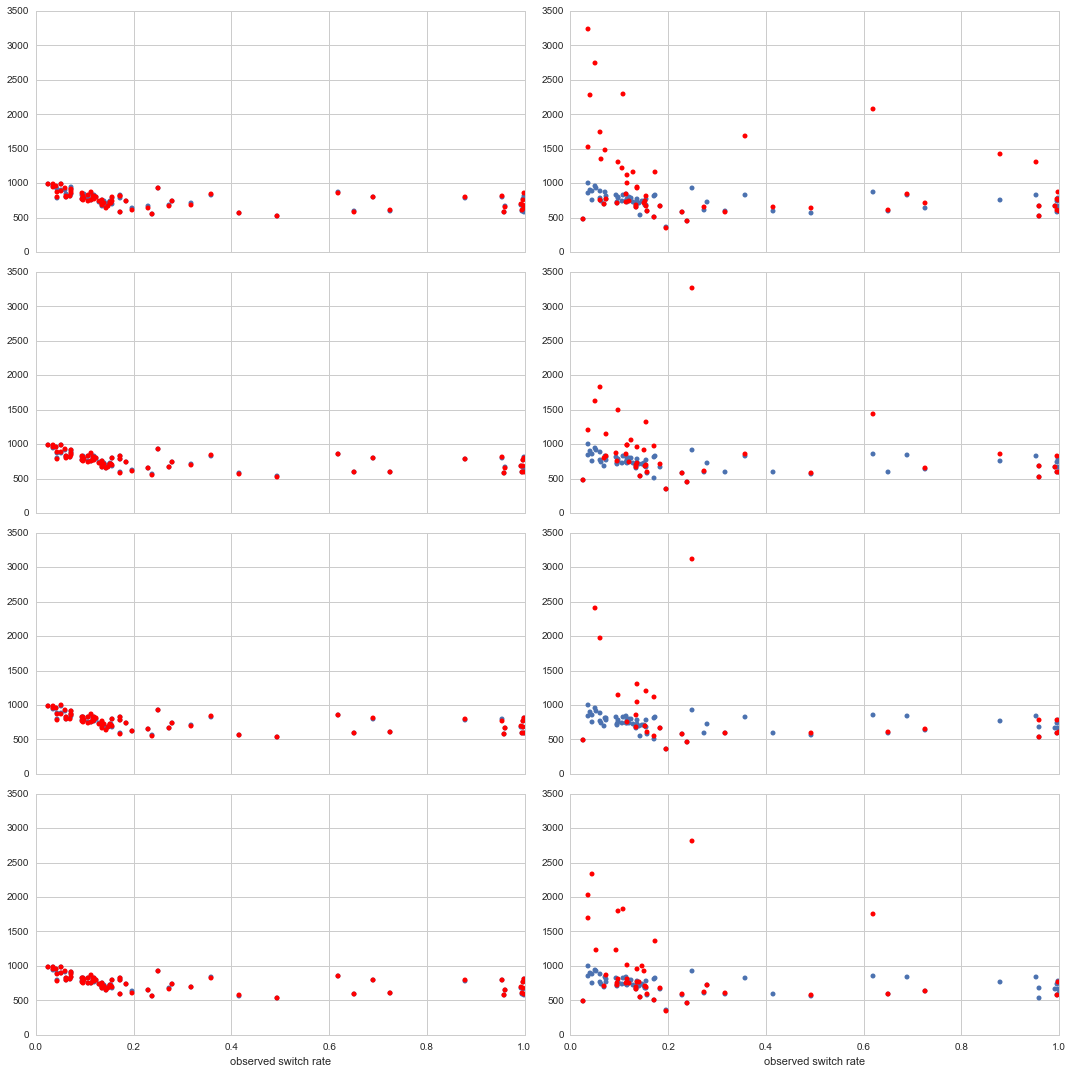

In [172]:
fig, axi = plt.subplots(4, 2, figsize=(15, 15), sharex=True)

for i, weighting in enumerate(['none', 'prob1', 'prob2', 'value1']):

    for j, stoprule in enumerate(['optional', 'normal']):
                
        mdf = swdf[(swdf.stoprule==stoprule) & (swdf.weighting==weighting)]
        
        ax = axi[i][j]
        ax.plot(mdf.switchrate, mdf.baseline, 'o', markersize=5)
        ax.plot(mdf.switchrate, mdf.switching, 'o', color='red', markersize=5)
        ax.set_ylim(0, 3500)
        
        if i==3:
            ax.set_xlabel('observed switch rate')

plt.tight_layout()
plt.show()
fig.savefig(FIGDEST+'switching_change_in_BIC.pdf', bbox_inches='tight')

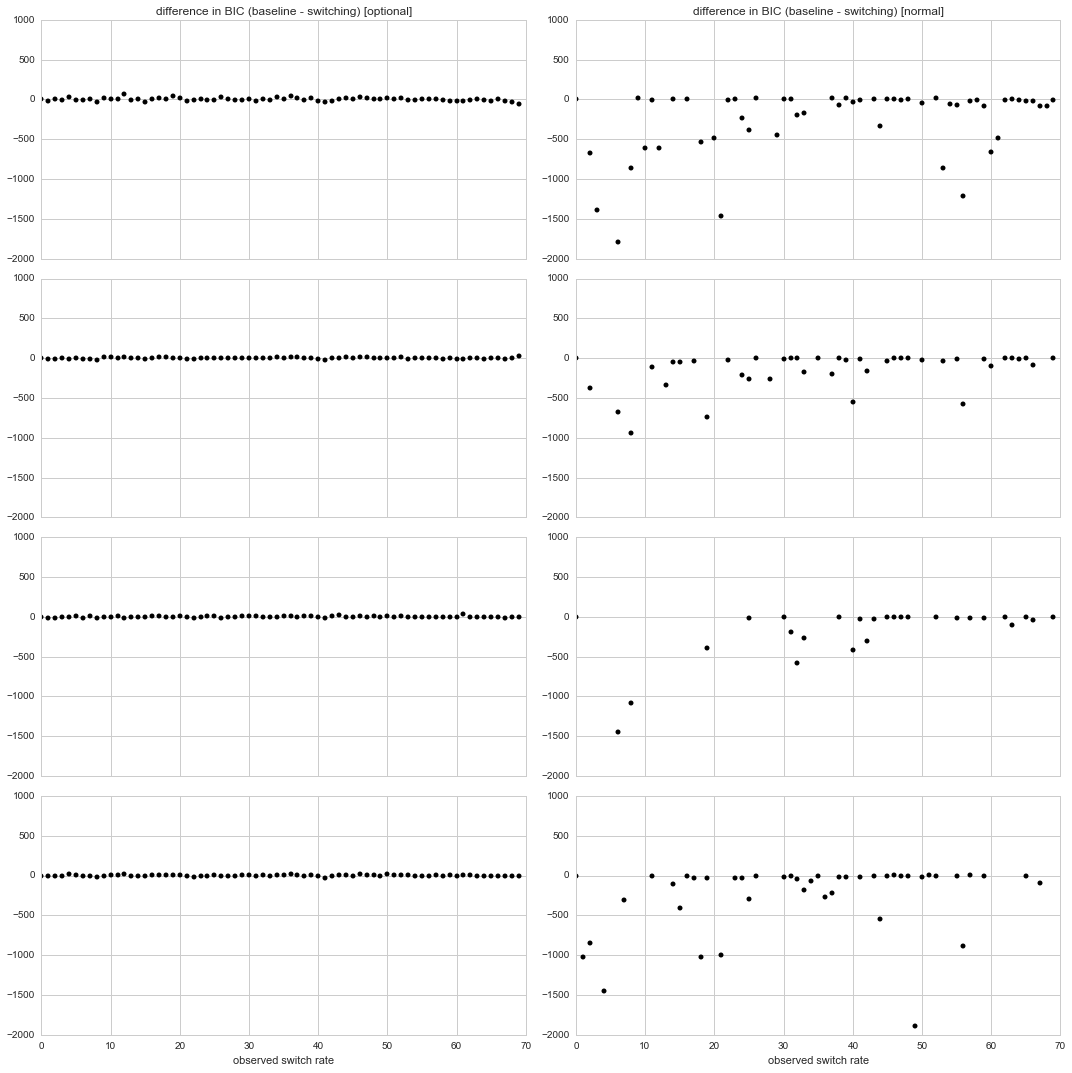

In [173]:
fig, axi = plt.subplots(4, 2, figsize=(15, 15), sharex=True)

for i, weighting in enumerate(['none', 'prob1', 'prob2', 'value1']):

    for j, stoprule in enumerate(['optional', 'normal']):
                
        mdf = swdf[(swdf.stoprule==stoprule) & (swdf.weighting==weighting)]
        mdf = mdf.sort('switchrate')
        
        ax = axi[i][j]
        ax.plot(mdf.baseline - mdf.switching, 'o', markersize=5, color='black')        
        ax.set_ylim(-2000, 1000)
        
        if i==0:
            ax.set_title('difference in BIC (baseline - switching) [%s]' % stoprule)
        
        if i==3:
            ax.set_xlabel('observed switch rate')


plt.tight_layout()
plt.show()
fig.savefig(FIGDEST+'switching_change_in_BIC_sorted.pdf', bbox_inches='tight')

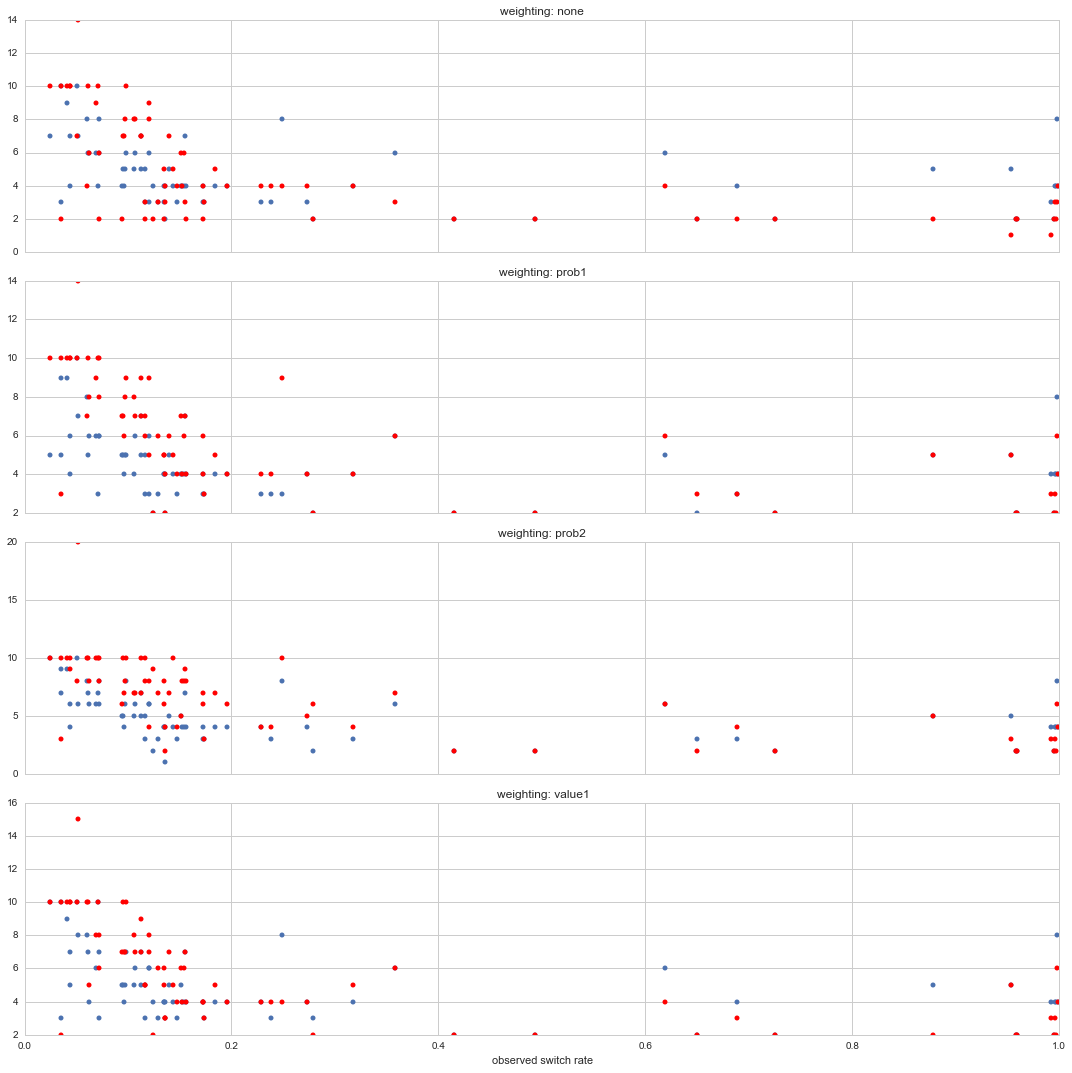

In [174]:
fig, axi = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

for i, weighting in enumerate(['none', 'prob1', 'prob2', 'value1']):

    for j, stoprule in enumerate(['optional']):
                
        mdf = swdf[(swdf.stoprule==stoprule) & (swdf.weighting==weighting)]
    
        ax = axi[i]
        ax.plot(mdf.switchrate, mdf.baseline_theta, 'o', markersize=5)
        ax.plot(mdf.switchrate, mdf.switching_theta, 'o', color='red', markersize=5)
        ax.set_title('weighting: ' + weighting)

axi[-1].set_xlabel('observed switch rate')
plt.tight_layout()
plt.show()
fig.savefig(FIGDEST+'switching_change_in_theta.pdf', bbox_inches='tight')

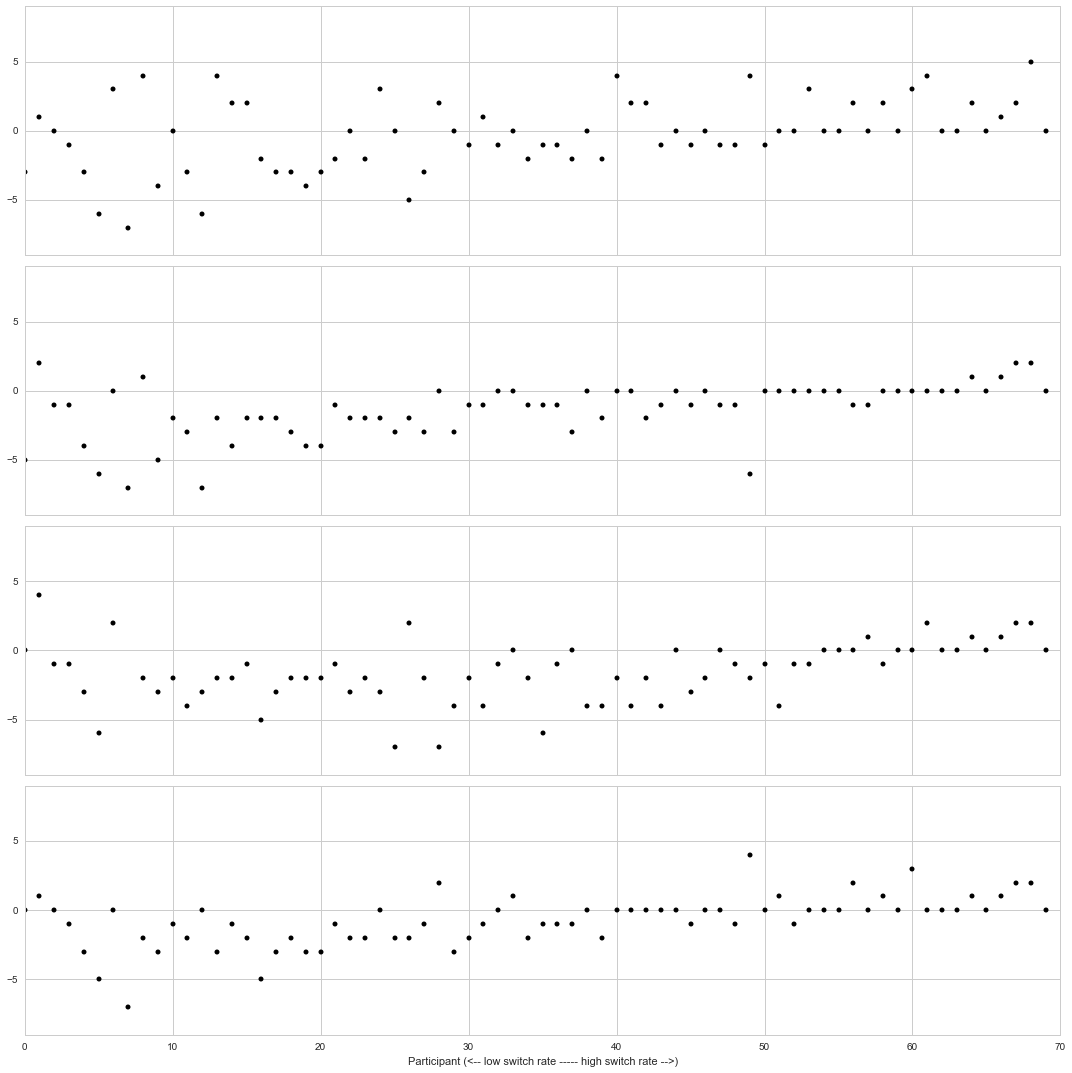

In [175]:
fig, axi = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

for i, weighting in enumerate(['none', 'prob1', 'prob2', 'value1']):

    for j, stoprule in enumerate(['optional']):
                
        mdf = swdf[(swdf.stoprule==stoprule) & (swdf.weighting==weighting)]
        mdf = mdf.sort('switchrate')
        
        ax = axi[i]
        ax.plot(mdf.baseline_theta - mdf.switching_theta, 'o', color='black', markersize=5)
        ax.set_ylim( -9, 9)

axi[-1].set_xlabel('Participant (<-- low switch rate ----- high switch rate -->)')
plt.tight_layout()
plt.show()
fig.savefig(FIGDEST+'switching_change_in_theta_sorted.pdf', bbox_inches='tight')

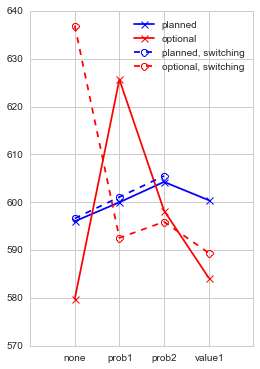

In [46]:
fitdf = model_table(33, force=True)

cols = ['blue', 'red']
styl = ['-x', '--o']

fig, ax = plt.subplots(figsize=(4,6))
ax.plot([lookup_bic(fitdf, False, 'normal', 'none'),
         lookup_bic(fitdf, False, 'normal', 'prob1'),
         lookup_bic(fitdf, False, 'normal', 'prob2'),
         lookup_bic(fitdf, False, 'normal', 'value1')], 
        styl[0], color=cols[0], label='planned',
        markerfacecolor=cols[0], markeredgecolor=cols[0], markeredgewidth=1)
ax.plot([lookup_bic(fitdf, False, 'optional', 'none'),
         lookup_bic(fitdf, False, 'optional', 'prob1'),
         lookup_bic(fitdf, False, 'optional', 'prob2'),
         lookup_bic(fitdf, False, 'optional', 'value1')], 
        styl[0], color=cols[1], label='optional', 
        markerfacecolor=cols[1], markeredgecolor=cols[1], markeredgewidth=1)
ax.plot([lookup_bic(fitdf, True, 'normal', 'none'),
         lookup_bic(fitdf, True, 'normal', 'prob1'),
         lookup_bic(fitdf, True, 'normal', 'prob2'),
         lookup_bic(fitdf, True, 'normal', 'value1')], 
        styl[1], color=cols[0], label='planned, switching',
        markerfacecolor='none', markeredgecolor=cols[0], markeredgewidth=1)
ax.plot([lookup_bic(fitdf, True, 'optional', 'none'),
         lookup_bic(fitdf, True, 'optional', 'prob1'),
         lookup_bic(fitdf, True, 'optional', 'prob2'),
         lookup_bic(fitdf, True, 'optional', 'value1')], 
        styl[1], color=cols[1], label='optional, switching',
        markerfacecolor='none', markeredgecolor=cols[1], markeredgewidth=1)
ax.legend()

ax.set_xticks(range(4))
ax.set_xticklabels(['none', 'prob1', 'prob2', 'value1'])
ax.set_xlim(-1, 4)
plt.show()

# Model weights

In [35]:
from mypy.viz import tableau20

In [36]:
stoprules = ['Optional', 'Normal', 'Geometric']
weighting = ['Value(2)', 'Value(1)', 'Prob(2)', 'Prob(1)', 'None']


col = []
labs = []
ind = [0, 4, 2]
for i in range(3):
    for j in range(5):
        col.append(.2 + np.array(tableau20[ind[i]]) * (.15 * (j+1)))
        labs.append('%s, %s' % (stoprules[i], weighting[j]))

In [37]:
arr = []
for j, sid in enumerate(data.subject.unique()):
    tab = model_table(sid, force=True)[['stoprule', 'weighting', 'W_bic']]
    arr.append([sid, tab[tab.stoprule=='optional'].W_bic.sum()])
arr = np.array(arr)

In [38]:
srted = np.array(arr[np.argsort(arr[:,1])][:,0], int)

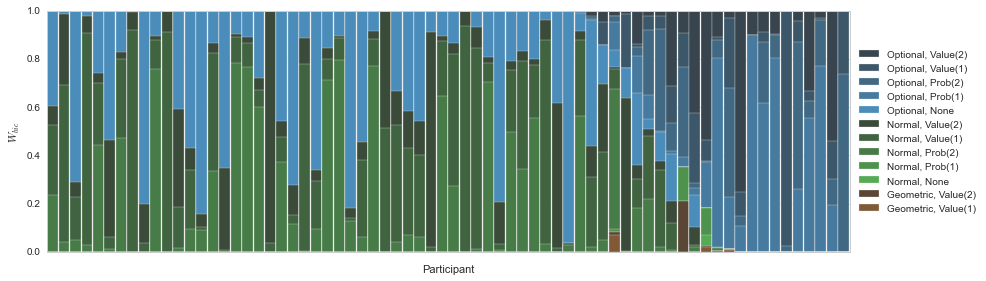

In [39]:
fig, ax = plt.subplots(figsize=(12,4))

for j, sid in enumerate(srted):

    tab = model_table(sid, force=True)[['stoprule', 'weighting', 'W_bic']]
    w = tab.sort(['stoprule', 'weighting']).W_bic.values
    
    for i, w_i in enumerate(np.cumsum(w)[::-1]):
        if j==0:
            ax.bar(j, w_i, color=col[i], alpha=1, width=.95, label=labs[i])
        else:
            ax.bar(j, w_i, color=col[i], alpha=1, width=.95)

ax.legend(loc='center left', bbox_to_anchor=(1, .5))
ax.set_ylim(0, 1)
ax.set_ylabel(r'$W_{bic}$')
ax.set_xlabel('Participant')
ax.set_xticklabels([])
plt.tight_layout()
plt.show()
#fig.savefig(FIGDEST + 'frey_model_weights.pdf', bbox_inches='tight')

In [46]:
labels = ['planned, prob', 'planned, value', 'optional, value', 'optional, prob']
col = [(1, 0, 0), (1, .6, .5), (.5, .6, 1), 'blue']
fig, ax = plt.subplots(figsize=(8,4))
for i, arr in enumerate(np.cumsum(w_srt, axis=1).transpose()[::-1]):
    #print arrb
    plt.bar(range(len(arr)), arr, color=col[i], alpha=1, width=.95, label=labels[i])
ax.set_ylim(0, 1)
ax.set_xlim(0, len(w_srt))
ax.set_xlabel('Participant')
ax.set_ylabel('Model weights')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
fig.savefig(FIGDEST+'frey_individual_modelweights.pdf', bbox_inches='tight')

3    8.802384e-68
4    1.365643e-67
5    1.182303e-68
6    1.167832e-01
7    8.789292e-01
8    4.287561e-03
0    1.435743e-61
1    8.768537e-60
2    2.730192e-61
Name: W_bic, dtype: float64

# Best-fit model

Looking good: 
1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 100, 101, 102, 103, 104, 106, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131 132, 133, 134, 135, 136, 137

Not so good: 126

Pattern:

- U-shaped: 4, 18, 20?, 

- Inverted-U: 
1, 2, 6, 8, 12, 13, 16, 23, 27, 30?, 31, 32, 34, 
35, 39, 100, 101, 102, 103, 104, 113, 114, 117, 118,
119, 120, 121, 122, 123, 124, 126, 128, 131, 132, 134, 
135, 136, 137

- Neither: 3, 7, 9, 15, 17, 21, 22, 24, 26, 28, 29, 33, 36, 37,
106, 109, 111, 112, 115, 116, 125, 127, 129, 130, 133



In [81]:
model_table(29)

,sim_id,stoprule,weighting,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss,W_bic
6,"frey_individual_planned_subj=29(mu,p_stay,sc,tau|c=0.5,theta=30)",normal,none,4,84,386.513628,790.750523,4.622154e-11,8.278388e-11,30,NaN,8.260355,21.349874,NaN,NaN,NaN,NaN,0.734790
0,"frey_individual_subj=29(p_stay,tau,theta|c=0.5)",optional,none,3,84,390.332035,793.956520,3.386315e-01,5.488692e-01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.147907
3,"frey_individual_planned_geom_subj=29(p_stay,p_stop,tau|c=0.5,theta=30)",geom,none,3,84,390.859946,795.012343,1.263479e-04,7.222179e-01,30,0.049218,NaN,NaN,NaN,NaN,NaN,NaN,0.087241
7,"frey_individual_planned_subj=29(mu,p_stay,prelec_elevation,prelec_gamma,sc,tau|c=0.5,theta=30)",normal,prob,6,84,386.270399,799.125699,2.379533e-09,1.589875e-08,30,NaN,8.260355,21.349874,1.091224,1.044273,NaN,NaN,0.011156
8,"frey_individual_planned_subj=29(mu,p_stay,pow_gain,sc,tau,w_loss|c=0.5,theta=30)",normal,value,6,84,386.367126,799.319153,4.622154e-11,8.641030e-10,30,NaN,8.260355,21.349874,NaN,NaN,0.905866,11.351716,0.010128
1,"frey_individual_subj=29(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5)",optional,prob,5,84,389.751402,801.656888,8.208205e-01,2.041095e-01,2,NaN,NaN,NaN,1.246827,1.141910,NaN,NaN,0.003147
2,"frey_individual_subj=29(p_stay,pow_gain,tau,theta,w_loss|c=0.5)",optional,value,5,84,389.883984,801.922053,3.420607e-01,5.510208e-01,4,NaN,NaN,NaN,NaN,NaN,0.836498,1.196585,0.002756
5,"frey_individual_planned_geom_subj=29(p_stay,p_stop,pow_gain,tau,w_loss|c=0.5,theta=30)",geom,value,5,84,390.421498,802.997079,3.437289e-07,2.856374e-01,30,0.049180,NaN,NaN,NaN,NaN,0.906463,2.329605,0.001610
4,"frey_individual_planned_geom_subj=29(p_stay,p_stop,prelec_elevation,prelec_gamma,tau|c=0.5,theta...",geom,prob,5,84,390.662613,803.479310,9.255841e-07,7.748588e-01,30,0.049210,NaN,NaN,1.486918,0.807103,NaN,NaN,0.001265


In [6]:
sid = 137
model_ind = 0
tab = model_table(sid)
stoprule, weighting = tab.iloc[model_ind][['stoprule', 'weighting']].values
p_ind = ['none', 'prob1', 'prob2', 'value1', 'value2'].index(weighting)
print stoprule
print weighting


if stoprule == 'optional':
    model_id = 'frey_individual_subj=%s' % sid
    fixed = FIXED_OPT
    fitting = {p: PARS[p] for p in PARSETS_OPT[p_ind]}
    
    # initialize the model
    m = CHASEModel(drift='cpt', startdist='laplace', problems=problems)

elif stoprule == 'geom':
    model_id = 'frey_individual_planned_geom_subj=%s' % sid
    fixed = FIXED
    fitting = {p: PARS[p] for p in PARSETS_GEOM[p_ind]}
    
    # initialize the model
    m = CHASEAlternateStoppingModel(drift='cpt',
                                    startdist='laplace',
                                    stoprule='geometric',
                                    problems=problems)

elif stoprule == 'normal':
    model_id = 'frey_individual_planned_subj=%s' % sid
    fixed = FIXED
    fitting = {p: PARS[p] for p in PARSETS_NORMAL[p_ind]}
    
    # initialize the model
    m = CHASEAlternateStoppingModel(drift='cpt',
                                    startdist='laplace',
                                    stoprule='truncatednormal',
                                    problems=problems)

pred = predict_from_result(m, problems, model_id, fixed=fixed, fitting=fitting, outdir=OUTDIR, max_T=200)

normal
value1


In [10]:
observed_samplesize = data[(data.subject==sid)].samplesize.values - 1
predicted_samplesize = []

observed = []
predicted = []

for gid in frey2014.gamble_lab_srt:
    obs = data[(data.subject==sid) & (data.problem==gid)]
    if obs.shape[0] > 0:
        choice, ss = obs[['choice', 'samplesize']].values[0]
        observed.append(choice)
        
        if stoprule == 'optional':
            predicted.append(pred[gid]['p_resp'][1])
            predicted_samplesize.append(pred[gid]['p_stop_cond'][:,0]*pred[gid]['p_resp'][0] + pred[gid]['p_stop_cond'][:,1]*pred[gid]['p_resp'][1])
        else:
            predicted.append(pred[gid]['p_resp_t'][ss - 1][1])
            predicted_samplesize.append(pred[gid]['p_stop'])
    else:
        observed.append(np.nan)
        predicted.append(np.nan)

observed_by_type = [np.nanmean(observed[:21]),
                    np.nanmean(observed[21:42]),
                    np.nanmean(observed[42:63]),
                    np.nanmean(observed[63:])]

predicted_by_type = [np.nanmean(predicted[:21]),
                     np.nanmean(predicted[21:42]),
                     np.nanmean(predicted[42:63]),
                     np.nanmean(predicted[63:])]

observed = np.array(observed)
predicted = np.array(predicted)

choseL = np.arange(len(observed))[np.array(observed)==0]
choseH = np.arange(len(observed))[np.array(observed)==1]

In [15]:
np.mean((observed - predicted)**2)

0.21864816245466834

In [17]:
observed_samplesize

array([20, 12, 18, 17,  0, 14, 22, 13, 17, 12, 11, 13, 15, 13, 12, 13, 24,
       12, 16, 10, 10, 17,  8, 15, 18,  0,  8, 25, 14, 15, 17, 14, 14, 14,
       25, 15, 13, 17, 19, 20,  9,  8, 27, 10, 10, 12,  0,  0, 19, 15, 14,
       18, 16, 21, 18, 11, 19, 15, 19, 21, 11, 12, 13, 26, 15, 14, 12,  0,
       16, 27, 14, 30, 11, 19, 12, 19, 15, 14, 19, 23, 25, 17, 15,  8])

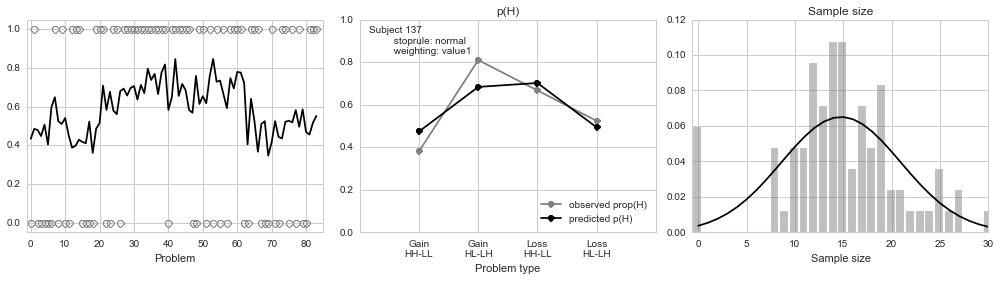

In [387]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

axi = ax[0]
axi.plot(choseH, np.ones(len(choseH)), 'o', color='gray', 
        markerfacecolor='none', markeredgecolor='gray', markeredgewidth=1)
axi.plot(choseL, np.zeros(len(choseL)), 'o', color='gray', 
        markerfacecolor='none', markeredgecolor='gray', markeredgewidth=1)
axi.plot(predicted, color='black')
axi.set_ylim(-.05,1.05)
axi.set_xlim(-1, 85)
axi.set_xlabel('Problem')

axi = ax[1]
axi.plot(observed_by_type, '-o', color='gray', label='observed prop(H)')
axi.plot(predicted_by_type, '-o', color='black', label='predicted p(H)')
axi.set_ylim(0, 1)
axi.set_xlim(-1, 4)
axi.set_xticks(range(4))
axi.set_xlabel('Problem type')
axi.set_xticklabels(['Gain\nHH-LL', 'Gain\nHL-LH', 'Loss\nHH-LL', 'Loss\nHL-LH'])
axi.set_title('p(H)')
axi.legend(loc='lower right')

axi = ax[2]
bc = np.bincount(observed_samplesize)
bc = bc / float(bc.sum())
axi.bar(np.arange(bc.size) - .5, bc, color='gray', alpha=.5)
axi.plot(np.array(predicted_samplesize).mean(axis=0),
         color='black')
axi.set_title('Sample size')
axi.set_xlim(-.6, observed_samplesize.max())
axi.set_xlabel('Sample size')

txt = '''Subject %s
         stoprule: %s
         weighting: %s''' % (sid, stoprule, weighting)
fig.text(.37, .8, txt)

plt.tight_layout()
plt.show()
fig.savefig(OUTDIR+'/bestmodel_subj=%s.pdf' % sid, bbox_inches='tight')

# Overall comparison

In [43]:
compdf = pd.DataFrame([], columns=['sid', 'cond', 'sim_id', 'stoprule', 'weighting', 'switching',
                                      'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                      'theta', 'p_stop', 'mu', 'sc', 
                                      'prelec_gamma', 'prelec_elevation',
                                      'pow_gain', 'w_loss'])
for sid in data.subject.unique():
    tab = model_table(sid, force=True)
    #tab = tab[tab.weighting!='none']
    compdf.loc[compdf.shape[0]] = tab.iloc[0]
    compdf.loc[compdf.shape[0]-1,'sid'] = sid
    compdf.loc[compdf.shape[0]-1,'cond'] = frey2014.condition(sid)

In [44]:
compdf

,sid,cond,sim_id,stoprule,weighting,switching,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss
0,1,old,"frey_individual_switching_planned_subj=1(mu,p_stay,sc,tau|c=0.5,p_switch=0.196,theta=30)",normal,none,True,4,84,164.819198,347.361662,9.278695e-06,2.192283e-05,30,NaN,9.707551,0.652254,NaN,NaN,NaN,NaN
1,2,old,"frey_individual_switching_subj=2(p_stay,tau,theta|c=0.5,p_switch=0.136)",optional,none,True,3,80,342.257916,697.661913,6.032235e-01,8.824740e-01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,old,"frey_individual_switching_planned_subj=3(mu,p_stay,sc,tau|c=0.5,p_switch=0.095,theta=30)",normal,none,True,4,84,344.810056,707.343378,5.406363e-01,1.133868e-02,30,NaN,20.305336,7.738785,NaN,NaN,NaN,NaN
3,4,old,"frey_individual_planned_subj=4(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)",normal,value1,False,5,84,277.423819,577.001722,5.039102e-01,1.150631e-07,30,NaN,13.712824,3.698612,NaN,NaN,5.033732,NaN
4,5,old,"frey_individual_planned_subj=5(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)",normal,value1,False,5,84,350.261851,722.677785,8.057516e-01,3.512040e-08,30,NaN,20.418267,8.306097,NaN,NaN,0.245704,NaN
5,6,old,"frey_individual_switching_subj=6(p_stay,tau,theta|c=0.5,p_switch=0.173)",optional,none,True,3,84,401.241476,815.775402,7.441159e-01,2.034636e-06,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,old,"frey_individual_subj=7(p_stay,prelec_gamma,tau,theta|c=0.5)",optional,prob1,False,4,83,479.358365,976.392093,6.279585e-01,2.007334e-01,5,NaN,NaN,NaN,0.626593,NaN,NaN,NaN
7,8,old,"frey_individual_planned_subj=8(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)",normal,value1,False,5,83,448.728692,919.551588,3.040561e-01,1.208560e-01,30,NaN,36.006194,42.504818,NaN,NaN,0.607023,NaN
8,9,old,"frey_individual_planned_subj=9(mu,p_stay,sc,tau|c=0.5,theta=30)",normal,none,False,4,80,353.158235,723.844576,9.491233e-01,6.177176e-01,30,NaN,16.008200,12.643947,NaN,NaN,NaN,NaN
9,12,old,"frey_individual_switching_subj=12(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,p_switch=...",optional,prob2,True,5,83,423.247000,868.588204,3.140797e-01,4.541998e-01,20,NaN,NaN,NaN,1.739054,0.156225,NaN,NaN


In [48]:
for i, row in compdf[:50].iterrows():
    print int(row['sid']), emp_p_switch[row['sid']], row['switching'], row['stoprule'], row['sim_id']

1 0.196 True normal frey_individual_switching_planned_subj=1(mu,p_stay,sc,tau|c=0.5,p_switch=0.196,theta=30)
2 0.136 True optional frey_individual_switching_subj=2(p_stay,tau,theta|c=0.5,p_switch=0.136)
3 0.095 True normal frey_individual_switching_planned_subj=3(mu,p_stay,sc,tau|c=0.5,p_switch=0.095,theta=30)
4 0.156 False normal frey_individual_planned_subj=4(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)
5 0.096 False normal frey_individual_planned_subj=5(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)
6 0.173 True optional frey_individual_switching_subj=6(p_stay,tau,theta|c=0.5,p_switch=0.173)
7 0.035 False optional frey_individual_subj=7(p_stay,prelec_gamma,tau,theta|c=0.5)
8 0.249 False normal frey_individual_planned_subj=8(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)
9 0.129 False normal frey_individual_planned_subj=9(mu,p_stay,sc,tau|c=0.5,theta=30)
12 0.052 True optional frey_individual_switching_subj=12(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,p_switch=0.052)
13 0.959 True opti

In [6]:
18/70.

0.2571428571428571

In [42]:
compdf['stoprule'].value_counts()

normal      52
optional    18
dtype: int64

In [43]:
print 52/70.
print 18/70.

0.742857142857
0.257142857143


In [44]:
compdf['weighting'].value_counts()

value1    24
none      21
prob1     20
prob2      5
dtype: int64

In [49]:
for stoprule in ['normal', 'optional']:
    for weighting in ['none', 'prob1', 'prob2', 'value1', 'value2']:
        sel = compdf[(compdf.stoprule==stoprule) & (compdf.weighting==weighting)]
        print stoprule, weighting
        print np.round(sel[['p_stay', 'tau', 'theta', 'p_stop', 'mu', 'sc', 
                   'prelec_gamma', 'prelec_elevation', 'pow_gain']].describe(percentiles=[]), 2)

normal none
       p_stay    tau  theta  p_stop     mu     sc  prelec_gamma  \
count   15.00  15.00     15       0  15.00  15.00             0   
mean     0.43   0.30     30     NaN  21.96  11.52           NaN   
std      0.42   0.35      0     NaN  16.94   7.96           NaN   
min      0.00   0.00     30     NaN   6.33   2.52           NaN   
50%      0.38   0.06     30     NaN  15.97   9.91           NaN   
max      1.00   1.00     30     NaN  61.52  25.45           NaN   

       prelec_elevation  pow_gain  
count                 0         0  
mean                NaN       NaN  
std                 NaN       NaN  
min                 NaN       NaN  
50%                 NaN       NaN  
max                 NaN       NaN  
normal prob1
       p_stay    tau  theta  p_stop     mu     sc  prelec_gamma  \
count   14.00  14.00     14       0  14.00  14.00         14.00   
mean     0.28   0.32     30     NaN  28.78  12.11          2.19   
std      0.35   0.31      0     NaN  16.19   6.47   

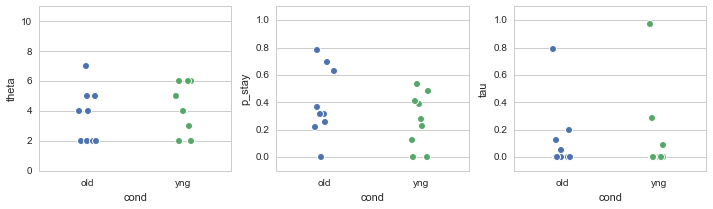

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
sns.stripplot(x='cond', y='theta', data=compdf[compdf.stoprule=='optional'], jitter=True, ax=ax[0])
sns.stripplot(x='cond', y='p_stay', data=compdf[compdf.stoprule=='optional'], jitter=True, ax=ax[1])
sns.stripplot(x='cond', y='tau', data=compdf[compdf.stoprule=='optional'], jitter=True, ax=ax[2])
ax[0].set_ylim(0, 11)
ax[1].set_ylim(-.1, 1.1)
ax[2].set_ylim(-.1, 1.1)
plt.tight_layout()
plt.show()

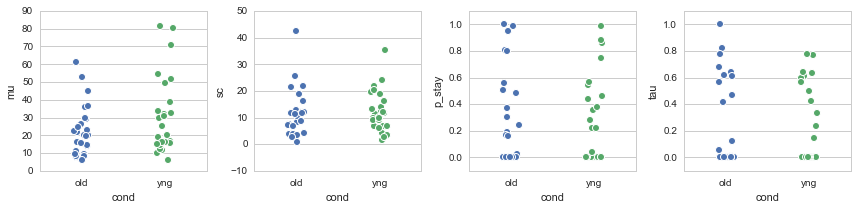

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
sns.stripplot(x='cond', y='mu', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[0])
sns.stripplot(x='cond', y='sc', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[1])
sns.stripplot(x='cond', y='p_stay', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[2])
sns.stripplot(x='cond', y='tau', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[3])
ax[2].set_ylim(-.1, 1.1)
ax[3].set_ylim(-.1, 1.1)
plt.tight_layout()
plt.show()

In [11]:
from chase.cpt import value_fnc

def prelec(p, prelec_elevation, prelec_gamma):
    return np.exp(-prelec_elevation * ((-np.log(p)) ** prelec_gamma))

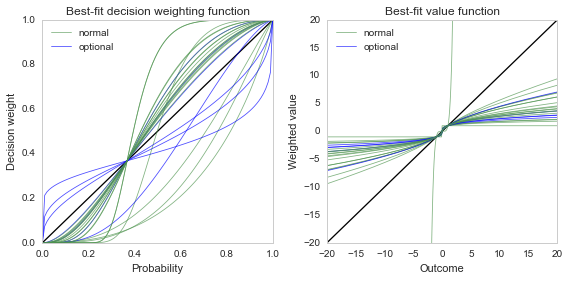

In [50]:
#col = {'old': 'red', 'yng': 'blue'}
#col = {'old': 'gray', 'yng': 'gray'}
col = {'normal': [ 0.30352941,  0.57647059,  0.30352941], 'optional': 'blue'}
al = .7
lw = .8

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

p = np.arange(0, 1.01, .01)
axi = ax[0]
axi.plot([0, 1], [0, 1], color='black', alpha=1, linewidth=1.3)

for i, row in compdf[compdf.weighting=='prob2'].iterrows():
    
    gamma, delta = row[['prelec_gamma', 'prelec_elevation']].values
    axi.plot(p, prelec(p, delta, gamma), color=col[row.stoprule], 
             alpha=al, linewidth=lw)

for i, row in compdf[compdf.weighting=='prob1'].iterrows():
    gamma, delta = row[['prelec_gamma', 'prelec_elevation']].values
    axi.plot(p, prelec(p, 1., gamma), color=col[row.stoprule], 
             alpha=al, linewidth=lw)

for sr in ['normal', 'optional']:
    axi.plot([-1,-1],[-1,-1], '-', alpha=al, linewidth=lw, color=col[sr], label=sr)
axi.legend(loc='upper left')
axi.set_ylim(0, 1)
axi.set_xlim(0, 1)




axi.set_title('Best-fit decision weighting function')
axi.set_xlabel('Probability')
axi.set_ylabel('Decision weight')
axi.grid(None)

axi = ax[1]
axi.plot([-20, 20], [-20, 20], color='black', alpha=1, linewidth=1.3)

x = np.arange(-30, 30, .1)
for i, row in compdf[compdf.weighting=='value2'].iterrows():
    alpha, lamb = row[['pow_gain', 'w_loss']].values
    #print alpha, lamb
    axi.plot(x, value_fnc(x, {'pow_gain': alpha, 'w_loss': lamb}), color=col[row.stoprule], 
             alpha=al, linewidth=lw)

    
for i, row in compdf[compdf.weighting=='value1'].iterrows():
    alpha, lamb = row[['pow_gain', 'w_loss']].values
    #print alpha, lamb
    axi.plot(x, value_fnc(x, {'pow_gain': alpha, 'w_loss': 1.}), color=col[row.stoprule], 
             alpha=al, linewidth=lw)

for sr in ['normal', 'optional']:
    axi.plot([-100,-100],[-100,-100], '-', alpha=al, linewidth=lw, color=col[sr], label=sr)
axi.legend(loc='upper left')


axi.set_ylim(-20, 20)
axi.set_xlim(-20, 20)
axi.set_title('Best-fit value function')
axi.set_xlabel('Outcome')
axi.set_ylabel('Weighted value')
axi.grid(None)

plt.tight_layout()
plt.show()
fig.savefig(FIGDEST+'frey_weighting_functions.pdf', bbox_inches='tight')

In [120]:
sset_opt = np.array(compdf[compdf.stoprule=='optional'].sid.values, int)
sset_norm = np.array(compdf[compdf.stoprule=='normal'].sid.values, int)

In [86]:
observed_by_type = {}
ss_by_type = {}
choiceprop = {}
for sid in data.subject.unique():
    observed = []
    samplesize = []
    for gid in frey2014.gamble_lab_srt:
        obs = data[(data.subject==sid) & (data.problem==gid)]
        if obs.shape[0] > 0:
            choice, ss = obs[['choice', 'samplesize']].values[0]
            observed.append(choice)
            samplesize.append(ss)
        else:
            observed.append(np.nan)
            samplesize.append(np.nan)

    choiceprop[sid] = np.nanmean(observed)
    
    observed_by_type[sid] = [np.nanmean(observed[:21]),
                             np.nanmean(observed[21:42]),
                             np.nanmean(observed[42:63]),
                             np.nanmean(observed[63:])]
    ss_by_type[sid] = [np.nanmean(samplesize[:21]),
                       np.nanmean(samplesize[21:42]),
                       np.nanmean(samplesize[42:63]),
                       np.nanmean(samplesize[63:])]

In [27]:
np.array([observed_by_type[sid] for sid in sset_opt]).mean(axis=0)

array([ 0.46307435,  0.68508772,  0.58586745,  0.50406572])

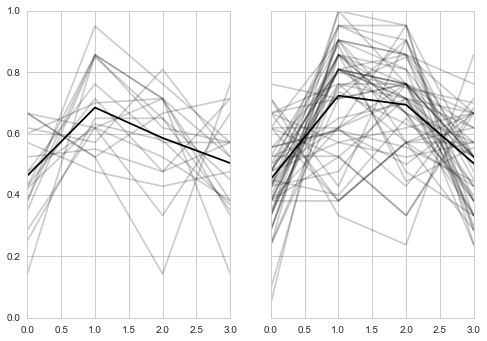

In [29]:
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(np.array([observed_by_type[sid] for sid in sset_opt]).transpose(), color='black', alpha=.2)
ax[0].plot(np.array([observed_by_type[sid] for sid in sset_opt]).mean(axis=0), color='black')
ax[1].plot(np.array([observed_by_type[sid] for sid in sset_norm]).transpose(), color='black', alpha=.2)
ax[1].plot(np.array([observed_by_type[sid] for sid in sset_norm]).mean(axis=0), color='black')
for axi in ax:
    axi.set_ylim(0, 1)
plt.show()

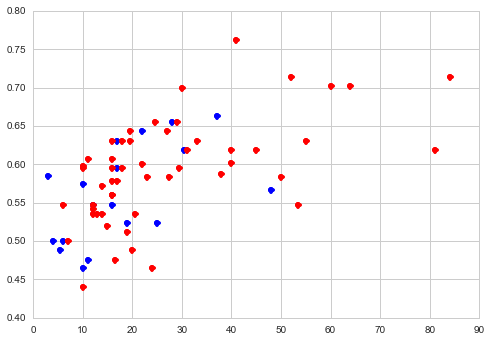

In [148]:
arr_opt = np.array([[np.mean(data[data.subject==sid].choice), np.median(data[data.subject==sid].samplesize)] \
                     for sid in sset_opt])

arr_norm = np.array([[np.mean(data[data.subject==sid].choice), np.median(data[data.subject==sid].samplesize)] \
                     for sid in sset_norm])


plt.plot(arr_opt[:,1], arr_opt[:,0], 'o', color='blue')
plt.plot(arr_norm[:,1], arr_norm[:,0], 'o', color='red')

In [185]:
arr = []
for x in arr_opt:
    arr.append(['optional', x[0], x[1]])
    
for x in arr_norm:
    arr.append(['normal', x[0], x[1]])
    
df = pd.DataFrame(arr, columns=['stoprule', 'acc', 'samplesize'])
df['eff'] = df['acc']/df['samplesize']

In [186]:
import seaborn as sns

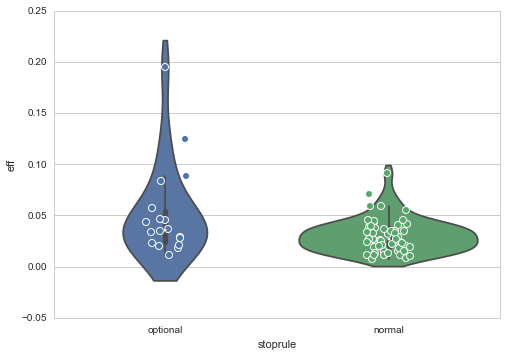

In [187]:
sns.violinplot(x='stoprule', y='eff', data=df, cut=True, alpha=.1)
sns.stripplot(x='stoprule', y='eff', data=df, jitter=True)